In [2]:
pip install librosa

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



You should consider upgrading via the 'C:\ProgramData\anaconda3\python.exe -m pip install --upgrade pip' command.


In [24]:
pip install sounddevice

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\ProgramData\anaconda3\python.exe -m pip install --upgrade pip' command.


# Importing Libraries

In [1]:
#Audio Processing Libraries
import librosa
from scipy import signal
#For Playing Audio
import IPython.display as ipd
#Array Processing
import numpy as np
#Data Visualization
import matplotlib.pyplot as plt

In [4]:
path='C:/Users/Aditya Sharma/Downloads/audio/emergency.wav'
emergency,sample_rate    = librosa.load(path, sr = 16000) #sr = Sampling Rate
path='C:/Users/Aditya Sharma/Downloads/audio/non emergency.wav'
non_emergency,sample_rate= librosa.load(path, sr =16000)

In [5]:
duration1 = librosa.get_duration(y=emergency,sr=16000)
duration2 = librosa.get_duration(y=non_emergency,sr=16000)
print("Duration of an emergency and Non Emergency (in min):",duration1/60,duration2/60)

Duration of an emergency and Non Emergency (in min): 22.920290625 27.160834375


# Data Pre-Processing

The below function divides the input audio samples into multiple chunks of audio with 3200 samples at a
sampling rate of 16000

In [6]:
def prepare_data(samples, num_of_samples=32000, num_of_common=16000):
    data=[]
    for offset in range(0, len(samples), num_of_common): #loop splitting audio into chunk with 3200 samples or 1600 sr
       start = offset
       end   = offset + num_of_samples
       chunk = samples[start:end]
       if(len(chunk)==32000):
         data.append(chunk)
    return data

In [7]:
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [8]:
print("No. of Chunks of Emergency and Non Emergency:",len(emergency),len(non_emergency))

No. of Chunks of Emergency and Non Emergency: 1374 1628


Plotting a random chunk of emergency and non emergency audio vehicle

Text(0, 0.5, 'Amplitude')

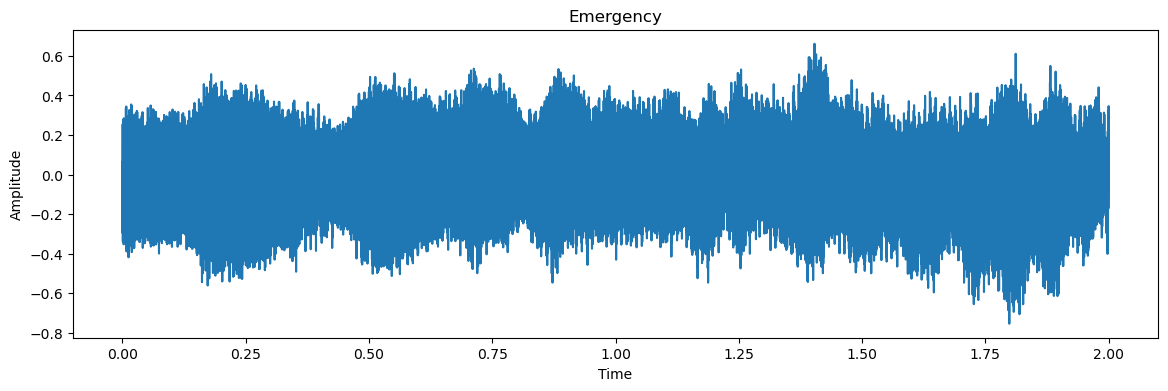

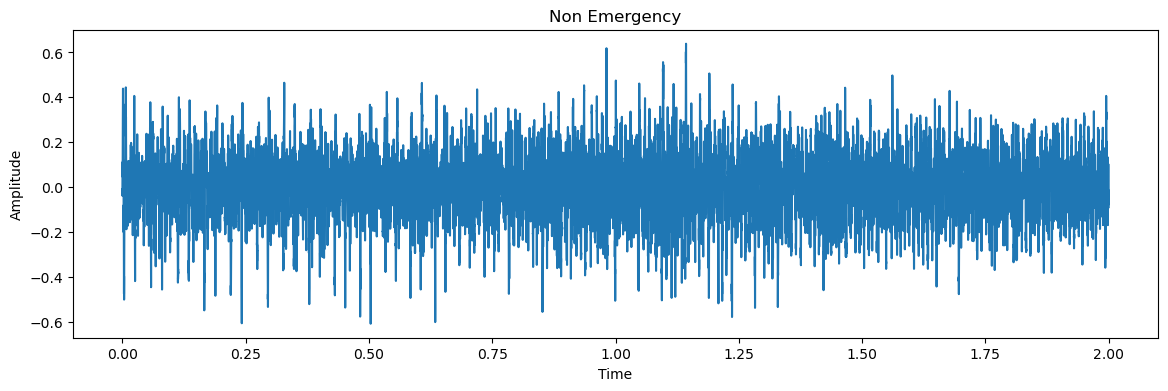

In [9]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[35])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[146])
plt.title('Non Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [10]:
# 1 for emergency label
# 0 for non emergency label

audio = np.concatenate([emergency,non_emergency])
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))
labels = np.concatenate([labels1,labels2])
print(audio.shape)

(3002, 32000)


In [11]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),stratify=labels,test_size = 0.1,
                                            random_state=777,shuffle=True)

In [12]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)
print("Reshaped Array Size (x_tr)",x_tr_features.shape)

Reshaped Array Size (x_tr) (2701, 32000, 1)


# Model Training (CNN)

In [13]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K
def cnn(x_tr):
      K.clear_session()
      inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))
       
      #First Conv1D layer
      conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
      conv = Dropout(0.3)(conv)
      conv = MaxPooling1D(2)(conv)
    
      #Second Conv1D layer
      conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
      conv = Dropout(0.3)(conv)
      conv = MaxPooling1D(2)(conv)
    
      #MaxPooling 1D
      conv = GlobalMaxPool1D()(conv)
    
      #Dense Layer 
      conv = Dense(16, activation='relu')(conv)
      outputs = Dense(1,activation='sigmoid')(conv)
      model = Model(inputs, outputs)
      model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
      model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_acc',
                                     verbose=1, save_best_only=True, mode='max')
      return model, model_checkpoint
    
    
model, model_checkpoint = cnn(x_tr_features)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 32000, 8)          112       
                                                                 
 dropout (Dropout)           (None, 32000, 8)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 16000, 8)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16000, 16)         1424      
                                                                 
 dropout_1 (Dropout)         (None, 16000, 16)         0         
                                                             

In [15]:
history=model.fit(x_tr_features, y_tr ,epochs=10,callbacks=[model_checkpoint], 
                  batch_size=32, validation_data=(x_val_features,y_val))

Epoch 1/10


85/85 [==============================] - ETA: 0s - loss: 0.6081 - acc: 0.7364
Epoch 1: val_acc improved from -inf to 0.81395, saving model to best_model.hdf5
85/85 [==============================] - 38s 393ms/step - loss: 0.6081 - acc: 0.7364 - val_loss: 0.5614 - val_acc: 0.8140
Epoch 2/10


C:\Users\Aditya Sharma\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - ETA: 0s - loss: 0.4215 - acc: 0.8397
Epoch 2: val_acc improved from 0.81395 to 0.85050, saving model to best_model.hdf5
85/85 [==============================] - 32s 379ms/step - loss: 0.4215 - acc: 0.8397 - val_loss: 0.4418 - val_acc: 0.8505
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.3505 - acc: 0.8649
Epoch 3: val_acc improved from 0.85050 to 0.86711, saving model to best_model.hdf5
85/85 [==============================] - 32s 380ms/step - loss: 0.3505 - acc: 0.8649 - val_loss: 0.3979 - val_acc: 0.8671
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.3252 - acc: 0.8723
Epoch 4: val_acc did not improve from 0.86711
85/85 [==============================] - 32s 378ms/step - loss: 0.3252 - acc: 0.8723 - val_loss: 0.3676 - val_acc: 0.8671
Epoch 5/10
85/85 [==============================] - ETA: 0s - loss: 0.3091 - acc: 0.8760
Epoch 5: val_acc improved from 0.86711 to 0.87375, saving model to best_model

In [16]:
model.load_weights('best_model.hdf5') #loading weights from pre trained model

# Model Evaluation

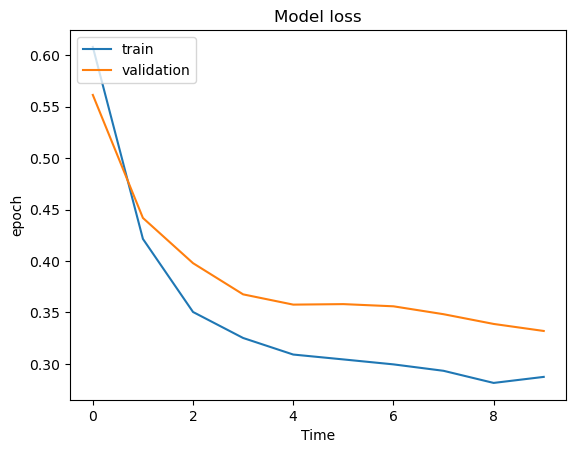

In [17]:
#summarize history for loss
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('Model loss')

plt.xlabel('Time')

plt.ylabel('epoch')

plt.legend(['train','validation'],loc = 'upper left')

plt.show()

# CNN Accuracy 

In [18]:
_, acc = model.evaluate(x_val_features,y_val)
print("Validation Accuracy:",acc)

10/10 [==============================] - 1s 77ms/step - loss: 0.3320 - acc: 0.8904
Validation Accuracy: 0.8903654217720032


In [19]:
len(x_val)

301

In [20]:
ind=10
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5 ):
 pred='emergency'
else:
 pred='non emergency'
print("Prediction:",pred)

1/1 [==============================] - 0s 339ms/step
Prediction: emergency


Text(0, 0.5, 'Amplitude')

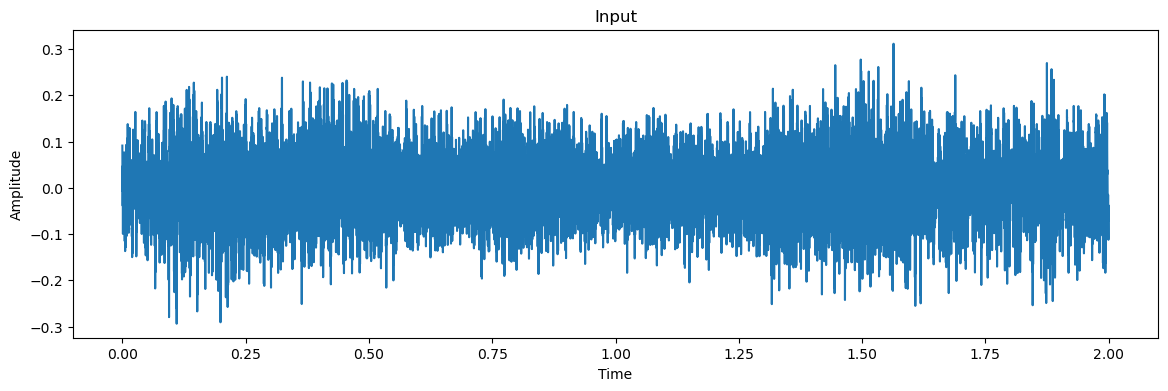

In [21]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),x_val[ind])
plt.title('Input')
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [22]:
import sounddevice as sd
sd.play(x_val[ind])

# LSTM Model

In [23]:
# reshaping the input sequence 
x_tr_features  = x_tr.reshape(len(x_tr),-1,160)
x_val_features = x_val.reshape(len(x_val),-1,160)
print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 200, 160)


In [24]:
def lstm(x_tr):
    K.clear_session()
    inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))
    #lstm
    x = LSTM(128)(inputs)
    x = Dropout(0.3)(x)
    #dense
    x= Dense(64,activation='relu')(x)
    x= Dense(1,activation='sigmoid')(x)
    model = Model(inputs, x)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    return model
model = lstm(x_tr_features)
model.summary()
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True,mode='max')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 160)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               147968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 156289 (610.50 KB)
Trainable params: 156289 (610.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
history=model.fit(x_tr_features, y_tr, epochs=10, callbacks=[mc], batch_size=32,validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6943 - acc: 0.5876
Epoch 1: val_acc improved from -inf to 0.62126, saving model to best_model.hdf5
85/85 [==============================] - 21s 183ms/step - loss: 0.6943 - acc: 0.5876 - val_loss: 0.6539 - val_acc: 0.6213
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.6066 - acc: 0.6723
Epoch 2: val_acc improved from 0.62126 to 0.66113, saving model to best_model.hdf5
85/85 [==============================] - 20s 236ms/step - loss: 0.6066 - acc: 0.6723 - val_loss: 0.6219 - val_acc: 0.6611
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.5701 - acc: 0.7049
Epoch 3: val_acc improved from 0.66113 to 0.68106, saving model to best_model.hdf5
85/85 [==============================] - 20s 232ms/step - loss: 0.5701 - acc: 0.7049 - val_loss: 0.5895 - val_acc: 0.6811
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.5681 - acc: 0.7234
Epoch 4: val_acc did not improve

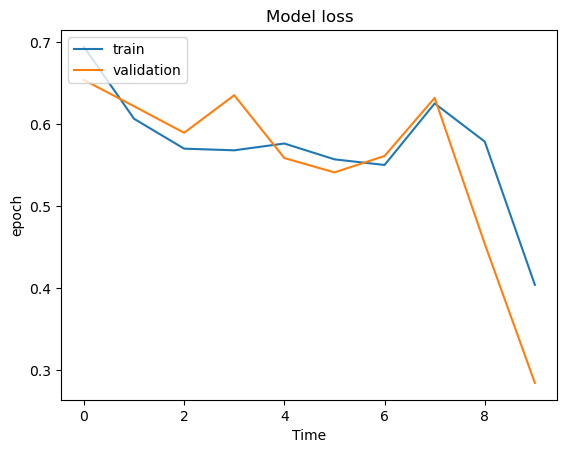

In [26]:
model.load_weights('best_model.hdf5')

#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Time')
plt.ylabel('epoch')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

# LSTM Accuracy 

In [27]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 1s 97ms/step - loss: 0.2842 - acc: 0.9103
Accuracy: 0.9102990031242371


# Spectrogram

In [28]:
def log_specgram(audio, sample_rate, eps=1e-10):
    nperseg  = 320
    noverlap = 160
    freqs, times, spec = signal.spectrogram(audio,fs=sample_rate,nperseg=nperseg,noverlap=noverlap,detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [29]:
def plot(spectrogram,label):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(211)
    ax.imshow(spectrogram.T, aspect='auto', origin='lower',extent=[times.min(),times.max(), freqs.min(), freqs.max()])
    ax.set_title('Spectrogram of '+label)
    ax.set_ylabel('Freqs in Hz')
    ax.set_xlabel('Seconds')

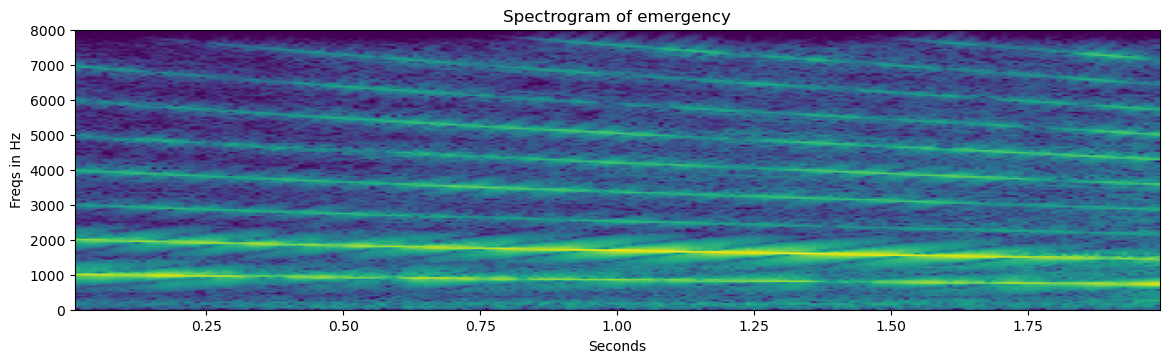

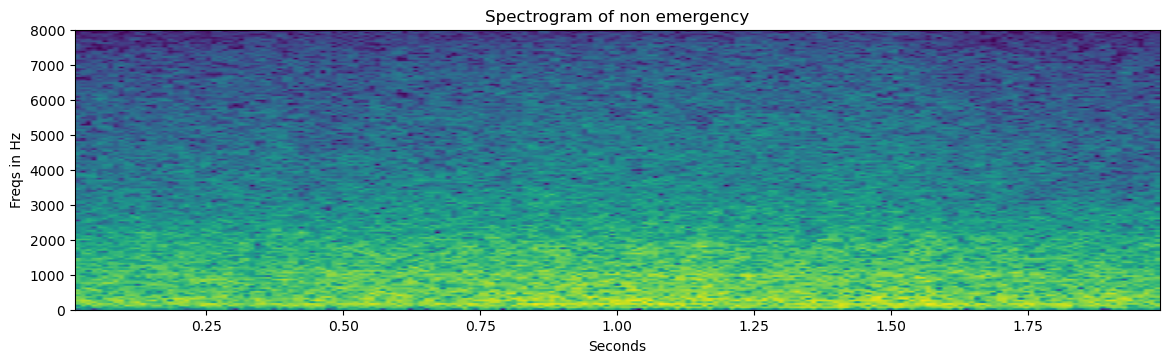

In [30]:
freqs, times, spectrogram = log_specgram(emergency[300], sample_rate)
plot(spectrogram,"emergency")
freqs, times, spectrogram = log_specgram(non_emergency[300], sample_rate)
plot(spectrogram,"non emergency")

In [31]:
spectrogram.shape

(199, 161)

In [32]:
def extract_spectrogram_features(x_tr):
    features=[]
    for i in x_tr:
       _, _, spectrogram = log_specgram(i, sample_rate)
       mean = np.mean(spectrogram, axis=0)
       std = np.std(spectrogram, axis=0)
       spectrogram = (spectrogram - mean) / std
       features.append(spectrogram)
    return np.array(features)

In [33]:
x_tr_features  = extract_spectrogram_features(x_tr)
x_val_features = extract_spectrogram_features(x_val)

In [34]:
model = lstm(x_tr_features)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 199, 161)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               148480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 156801 (612.50 KB)
Trainable params: 156801 (612.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
history=model.fit(x_tr_features, y_tr, epochs=10, callbacks=[mc],   batch_size=32, validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6603 - acc: 0.6094
Epoch 1: val_acc did not improve from 0.91030
85/85 [==============================] - 11s 102ms/step - loss: 0.6603 - acc: 0.6094 - val_loss: 0.5918 - val_acc: 0.6944
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.4361 - acc: 0.8256
Epoch 2: val_acc did not improve from 0.91030
85/85 [==============================] - 12s 137ms/step - loss: 0.4361 - acc: 0.8256 - val_loss: 0.4370 - val_acc: 0.8106
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.3314 - acc: 0.8704
Epoch 3: val_acc did not improve from 0.91030
85/85 [==============================] - 10s 116ms/step - loss: 0.3314 - acc: 0.8704 - val_loss: 0.2955 - val_acc: 0.8704
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.2329 - acc: 0.9156
Epoch 4: val_acc improved from 0.91030 to 0.92691, saving model to best_model.hdf5
85/85 [==============================] - 11s 128ms/step -

# LSTM + Spectrograph Accuracy

In [36]:
model.load_weights('best_model.hdf5')
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 0s 43ms/step - loss: 0.1427 - acc: 0.9535
Accuracy: 0.9534883499145508
